Goal: create a model that predicts severity of a collision, based on the features of the collision

In [16]:
import pandas as pd
import numpy as np
import pylab as pl
%pylab inline
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.linear_model import RandomizedLasso
from sklearn.metrics import median_absolute_error
from sklearn.linear_model import LinearRegression

Populating the interactive namespace from numpy and matplotlib


1) Load data  
    - 2014 attendant, vehicle, and casualty datasets
    - Description of data: https://drive.google.com/drive/u/0/folders/1afX9SJzqmO6rQG6FDhpMlzOfoy_NwI7Q
    - Merge on AREFNO
2) Train, Test split  
3) Hyper Paramter tuning for Random Forest Classifier  
3) Feature Importance  
4) Next: Visualize a decision tree  

In [31]:
def feat_sel(X, y, model='rf', alpha=100, feat_num=20):
    '''
    performs random forest or lasso fit on specified dataframe and produces a list of 
    the top specified number of features and returns a sorted list of the features and their scores.
    '''
    #regressors = list(set(df.columns) - set([output]))

    #y = df[output]
    #X = df[regressors] #select all the columns after id and geography -- the regressors
    names = X.columns

    #rlasso = RandomizedLasso(alpha=alpha,random_state=0, normalize=True, fit_intercept=True)
    #rlasso.fit(X, y)

    rf = RandomForestClassifier(n_jobs=-1, random_state=0,n_estimators=100)
    rf.fit(X, y)

    if model == 'lasso':
        feat_sort = (sorted(zip(map(lambda x: round(x, 10), rlasso.scores_), names), reverse=True))
    else: 
        feat_sort = (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True))
        print ('R-Score', rf.score(X, y))

    pl.figure(figsize=(8,6))
    pl.title("{} Feature importance".format(model))
    pl.bar(np.arange(feat_num), pd.DataFrame(feat_sort)[0][:feat_num], align='center')
    pl.xticks(np.arange(feat_num))
    pl.ylabel('Importance Score')

    print("{} Feature ranking:".format(model), pd.DataFrame(feat_sort)[:5])
    return feat_sort

** * Load Data * **

In [2]:
df_att = pd.read_csv('./data/2014-gla-data-extract-attendant.csv')
df_att.head()

,AREFNO,Borough,Boro,Easting,Northing,Location,Accident Severity,No. of Casualties in Acc.,No. of Vehicles in Acc.,Accident Date,...,Junction Detail,Junction Control,Road Class 2,Road No. 2,Ped. Crossing Decoded,Light Conditions (Banded),Weather,Road Surface,Special Conditions,C/W Hazard
0,0114CP00001,CITY OF LONDON,0,533540,181230,ST BOTOLPH STREET J/W HOUNDSDITCH,3 Slight,1,1,01-Jan-14,...,3 T/Stag Jun,4 Give Way/Uncontrolled,A,1211,0 No Xing Facility In 50m,2 Dark,1 Fine,2 Road-Wet,0 None,0 None
1,0114CP00002,CITY OF LONDON,0,532680,181430,MOORGATE J/W GREAT SWAN ALLEY,3 Slight,1,1,08-Jan-14,...,3 T/Stag Jun,4 Give Way/Uncontrolled,C,0,0 No Xing Facility In 50m,1 Daylight,1 Fine,1 Road-Dry,0 None,0 None
2,0114CP00003,CITY OF LONDON,0,532090,181830,ALDERGATE STREET J/W LONG LANE,2 Serious,1,1,09-Jan-14,...,3 T/Stag Jun,2 Auto Sig,C,0,5 Pedn Phase At Ats,2 Dark,1 Fine,1 Road-Dry,0 None,0 None
3,0114CP00004,CITY OF LONDON,0,531770,180950,QUEEN VICTORIA STREET J/W PUDDLE DOCK,2 Serious,1,2,08-Jan-14,...,3 T/Stag Jun,2 Auto Sig,C,0,5 Pedn Phase At Ats,1 Daylight,1 Fine,1 Road-Dry,0 None,0 None
4,0114CP00005,CITY OF LONDON,0,533130,180920,FENCHURCH STREET J/W ROOD LANE,3 Slight,1,1,15-Jan-14,...,3 T/Stag Jun,4 Give Way/Uncontrolled,C,0,0 No Xing Facility In 50m,1 Daylight,1 Fine,1 Road-Dry,0 None,0 None


In [3]:
df_cas = pd.read_csv('./data/2014-gla-data-extract-casualty.csv')
df_cas.head()

,AREFNO,Borough,Boro,Easting,Northing,CREFNO,Casualty Class,Casualty Sex,Casualty Age (Banded),Casualty Age,No. of Casualties,Casualty Severity,Ped. Location,Ped. Movement,Mode of Travel,
0,0114CP00001,CITY OF LONDON,0,533540,181230,1,3 Pedestrian,1 Male,25-59,29,1,3 Slight,05 Crossing Road (Not On Xing),9 Unknown Or Other,1 Pedestrian,
1,0114CP00002,CITY OF LONDON,0,532680,181430,1,3 Pedestrian,1 Male,25-59,48,1,3 Slight,05 Crossing Road (Not On Xing),9 Unknown Or Other,1 Pedestrian,
2,0114CP00003,CITY OF LONDON,0,532090,181830,1,3 Pedestrian,1 Male,Unknown,0,1,2 Serious,01 Crossing Road On Ped Xing,3 From Drivers O/Side,1 Pedestrian,
3,0114CP00004,CITY OF LONDON,0,531770,180950,1,1 Driver/Rider,1 Male,25-59,33,1,2 Serious,-2 Unknown,-2 N/A,3 Powered 2 Wheeler,
4,0114CP00005,CITY OF LONDON,0,533130,180920,1,3 Pedestrian,1 Male,25-59,31,1,3 Slight,06 On Footpath - Verge,9 Unknown Or Other,1 Pedestrian,


In [4]:
df_veh = pd.read_csv('./data/2014-gla-data-extract-vehicle.csv')
df_veh.head()

,AREFNO,Borough,Boro,Easting,Northing,Vehicle Ref.,Vehicle Type,Vehicle Type (Banded),Vehicle Manoeuvres,Vehicle Skidding,...,Junction Location,Object in C/W,Veh. Leaving C/W,Veh. off C/W,Veh. Impact,VJNYPURP DECODED,Driver Sex,Driver Age,Driver Age (Banded),
0,0114CP00001,CITY OF LONDON,0,533540,181230,1,08 Taxi,4 Taxi,18 Going Ahead Other,0 No Skidding/Overturn,...,1 Jct App,00 None,0 Did Not Leave,00 None,1 Front Hit First,5 Other/Not Known,1 Male,55,35-64,
1,0114CP00002,CITY OF LONDON,0,532680,181430,1,21 Gds => 7.5t,7 Goods vehicles,01 Reversing,0 No Skidding/Overturn,...,8 Jct Mid,00 None,0 Did Not Leave,00 None,2 Back Hit First,5 Other/Not Known,3 Not Traced,0,Unknown,
2,0114CP00003,CITY OF LONDON,0,532090,181830,1,09 Car,3 Car,18 Going Ahead Other,0 No Skidding/Overturn,...,8 Jct Mid,00 None,0 Did Not Leave,00 None,1 Front Hit First,2 Comm To/From Work,1 Male,57,35-64,
3,0114CP00004,CITY OF LONDON,0,531770,180950,1,09 Car,3 Car,18 Going Ahead Other,0 No Skidding/Overturn,...,1 Jct App,00 None,0 Did Not Leave,00 None,3 O/S Hit First,1 Jny Part of Work,1 Male,45,35-64,
4,0114CP00004,CITY OF LONDON,0,531770,180950,2,03 M/C 50-125cc,2 Powered 2 wheeler,13 Overtake Move Veh O/S,0 No Skidding/Overturn,...,1 Jct App,00 None,0 Did Not Leave,00 None,4 N/S Hit First,2 Comm To/From Work,1 Male,33,25-34,


In [5]:
print ('len df_att: ', len(df_att))
print ('len df_cas: ', len(df_cas))
len(pd.merge(df_att, df_cas, on='AREFNO', how='inner'))

len df_att:  25992
len df_cas:  30785


30785

More casualities than attendants entries -- more than one casuality per accident

Merge keeping the duplicates

In [6]:
df_crash = pd.merge(df_att, df_cas, on='AREFNO', how='inner')

print ('len df_crash: ', len(df_crash))
print ('len df_veh: ', len(df_veh))
len(pd.merge(df_crash, df_veh, on='AREFNO', how='inner'))

len df_crash:  30785
len df_veh:  46074


56406

Each accident has more than one vehicle. Merge to keep duplicates.

In [7]:
df_crash = pd.merge(df_crash, df_veh, on='AREFNO', how='inner')

In [8]:
df_crash['Casualty Class'].value_counts()

1 Driver/Rider    40640
2 Passenger        9916
3 Pedestrian       5850
Name: Casualty Class, dtype: int64

In [9]:
df_crash.columns

Index(['AREFNO', 'Borough_x', 'Boro_x', 'Easting_x', 'Northing_x', 'Location',
       'Accident Severity', 'No. of Casualties in Acc.',
       'No. of Vehicles in Acc.', 'Accident Date', 'Day', 'Time', 'Highway',
       'Road Class 1', 'Road No. 1', 'Road Type', 'Speed Limit',
       'Junction Detail', 'Junction Control', 'Road Class 2', 'Road No. 2',
       'Ped. Crossing Decoded', 'Light Conditions (Banded)', 'Weather',
       'Road Surface', 'Special Conditions', 'C/W Hazard', 'Borough_y',
       'Boro_y', 'Easting_y', 'Northing_y', 'CREFNO', 'Casualty Class',
       'Casualty Sex', 'Casualty Age (Banded)', 'Casualty Age',
       'No. of Casualties', 'Casualty Severity', 'Ped. Location',
       'Ped. Movement', 'Mode of Travel', ' _x', 'Borough', 'Boro', 'Easting',
       'Northing', 'Vehicle Ref.', 'Vehicle Type', 'Vehicle Type (Banded)',
       'Vehicle Manoeuvres', 'Vehicle Skidding', 'Restricted Lane',
       'Junction Location', 'Object in C/W', 'Veh. Leaving C/W',
       'Veh.

In [26]:
df_crash.Time = [int(x.strip("'")) for x in df_crash.Time]

In [44]:
df_crash['Object in C/W'].unique()

array(['00 None', '08 Hit Open Door', '04 Hit Parked Veh',
       '11 Hit Oth Object', '10 Hit Kerb', '07 Hit Bollard',
       '02 Hit Road Works', '01 Hit Prev Acc', '09 Hit Roundabout',
       '12 Hit Animal (Not Rid Horse)', '06 Hit Brdg Side',
       '05 Hit Brdg Roof'], dtype=object)

***2) Train, Test split  ***

In [27]:
df_crash.isnull().sum().sum()

0

In [46]:
# Select X and y data

y = df_crash['Accident Severity']

X = df_crash[[
    'Day', 'Time', 'Highway',
       'Road Class 1', 'Road Type', 'Speed Limit',
       'Junction Detail', 'Junction Control', 'Road Class 2', 
       'Ped. Crossing Decoded', 'Light Conditions (Banded)', 'Weather',
       'Road Surface', 'Special Conditions', 'C/W Hazard', 'Casualty Class',
       'No. of Casualties', 'Ped. Location',
       'Ped. Movement', 'Mode of Travel', 'Vehicle Type',
        'Vehicle Type (Banded)',
       'Vehicle Manoeuvres', 'Vehicle Skidding', 'Restricted Lane',
       'Junction Location', 'Object in C/W', 'Veh. Leaving C/W',
       'Veh. off C/W', 'Veh. Impact', 'VJNYPURP DECODED']]

print ('X shape: ', X.shape)
print ('y shape: ', y.shape)

X=pd.get_dummies(X)
print ('X shape: ', X.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=0)

X shape:  (56406, 31)
y shape:  (56406,)
X shape:  (56406, 222)


***4) Feature Importance  ***

In [47]:
rf = RandomForestClassifier(n_jobs=-1, random_state=0,n_estimators=100)

rf=rf.fit(X_train,y_train)#run predictor with each parameter using training data
pred=rf.predict(X_test)

print ('Accuracy: %.2f' % ((len(y_test[pred == y_test])/len(y_test))*100))


Accuracy: 93.50


R-Score 0.999929085558
rf Feature ranking:         0                              1
0  0.1625                           Time
1  0.0178  Veh. Impact_1 Front Hit First
2  0.0174                  Day_Thursday 
3  0.0169                  Day_Tuesday  
4  0.0168                 Road Class 1_A


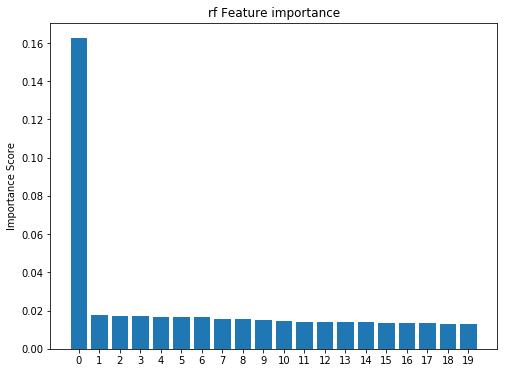

In [48]:
rf_res = pd.DataFrame(feat_sel(X, y, model='rf'))

In [34]:
rf_res.head(15)

,0,1
0,0.1520,Time
1,0.0256,No. of Vehicles in Acc.
2,0.0175,Day_Friday
3,0.0174,Veh. Impact_1 Front Hit First
4,0.0170,Road Class 1_A
5,0.0166,Day_Tuesday
6,0.0163,Vehicle Manoeuvres_18 Going Ahead Other
7,0.0160,Day_Thursday
8,0.0158,Day_Wednesday
9,0.0150,Day_Monday


*** Visualizing some data ***

In [37]:
colors = dict(zip(y.unique(), ['yellow', 'orange', 'red']))

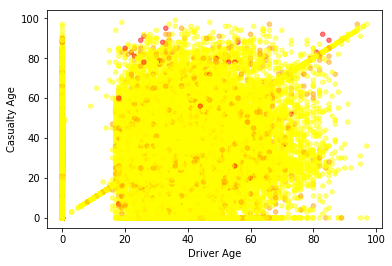

In [38]:
df_crash.plot.scatter(x="Driver Age",y="Casualty Age",c=y.replace(colors), alpha=.5)

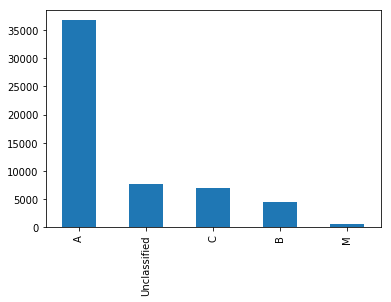

In [115]:
df_crash['Road Class 1'].value_counts().plot(kind='bar')

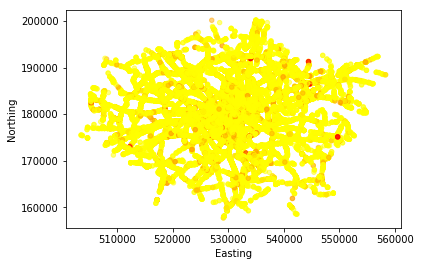

In [121]:
df_crash[df_crash['Road Class 1'] == 'A'].plot.scatter(x='Easting', y='Northing', c=y.replace(colors), alpha=.5)

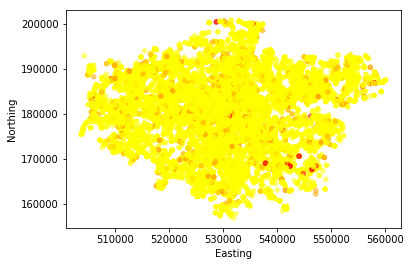

In [122]:
df_crash[df_crash['Road Class 1'] != 'A'].plot.scatter(x='Easting', y='Northing', c=y.replace(colors), alpha=.5)

In [125]:
# Select X and y data

y = df_crash['Accident Severity']

X = df_crash[[
       'Day', 'Time', 'Highway',
       'Road Type', 'Speed Limit',
       'Junction Detail', 'Junction Control', 
       'Ped. Crossing Decoded', 'Light Conditions (Banded)', 'Weather',
       'Road Surface', 'Special Conditions', 'C/W Hazard', 'Casualty Class',
       'No. of Casualties', 'Ped. Location',
       'Ped. Movement', 'Mode of Travel', 
       'Vehicle Manoeuvres', 'Vehicle Skidding', 'Restricted Lane',
       'Junction Location', 'Object in C/W', 'Veh. Leaving C/W',
       'Veh. off C/W',  'VJNYPURP DECODED']]

print ('X shape: ', X.shape)
print ('y shape: ', y.shape)

X=pd.get_dummies(X)
print ('X shape: ', X.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=0)

X shape:  (56406, 26)
y shape:  (56406,)
X shape:  (56406, 1564)


R-Score 0.999290855583
rf Feature ranking:         0                             1
0  0.0148                Highway_1 TLRN
1  0.0145                 Highway_3 Bor
2  0.0139                 Day_Tuesday  
3  0.0138  Junction Detail_3 T/Stag Jun
4  0.0137   Junction Location_8 Jct Mid


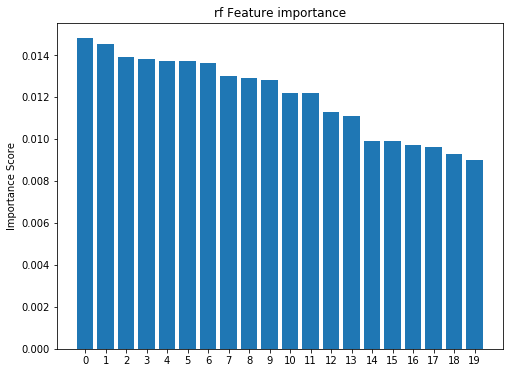

In [126]:
rf_res = pd.DataFrame(feat_sel(X, y, model='rf'))

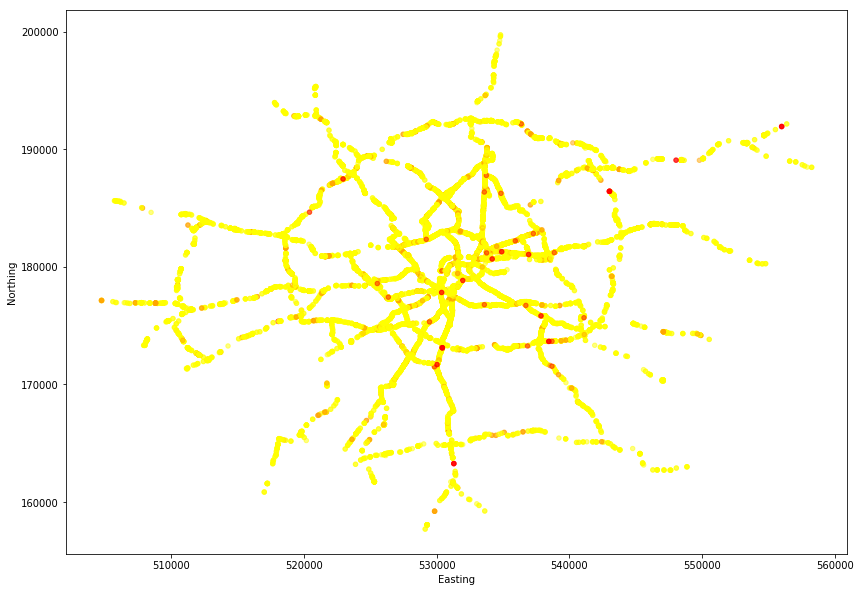

In [40]:
df_crash[df_crash['Highway'] == '1 TLRN']\
.plot.scatter(x='Easting', y='Northing', 
              c=y[df_crash['Highway'] == '1 TLRN'].replace(colors),
              figsize=(14,10), alpha=.5)

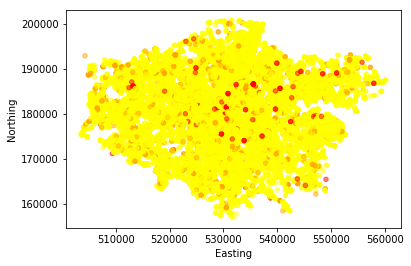

In [139]:
df_crash[df_crash['Highway'] != '1 TLRN'].plot.scatter(x='Easting', y='Northing', c=y[df_crash['Highway'] != '1 TLRN'].replace(colors), alpha=.5)

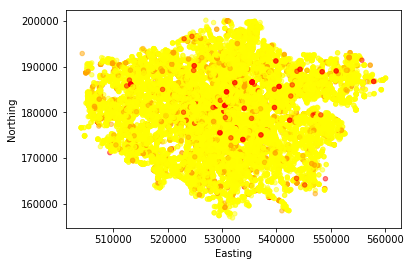

In [138]:
df_crash[df_crash['Highway'] == '3 Bor'].plot.scatter(x='Easting', y='Northing', c=y[df_crash['Highway'] == '3 Bor'].replace(colors), alpha=.5)

In [136]:
df_crash[df_crash['Day'] == 'Tuesday']#.plot.scatter(x='Easting', y='Northing', c=y.replace(colors), alpha=.5)

,AREFNO,Borough_x,Boro_x,Easting_x,Northing_x,Location,Accident Severity,No. of Casualties in Acc.,No. of Vehicles in Acc.,Accident Date,...,Junction Location,Object in C/W,Veh. Leaving C/W,Veh. off C/W,Veh. Impact,VJNYPURP DECODED,Driver Sex,Driver Age,Driver Age (Banded),_y


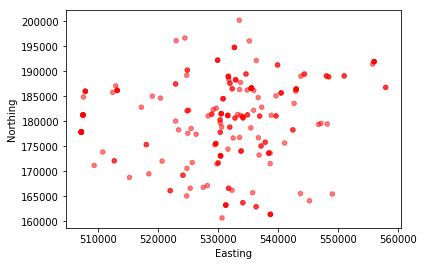

In [141]:
df_crash[df_crash['Accident Severity'] == '1 Fatal'].plot.scatter(x='Easting', y='Northing', c=y[df_crash['Accident Severity'] == '1 Fatal'].replace(colors), alpha=.5)

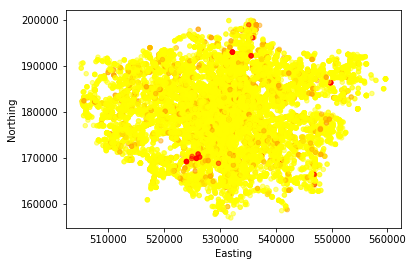

In [142]:
df_crash[df_crash['Junction Detail'] == '3 T/Stag Jun'].plot.scatter(x='Easting', y='Northing', c=y.replace(colors), alpha=.5)

In [143]:
feat = ['Junction Detail']

In [145]:
for x in feat:
    fig = plt.figure(figsize=(16, 14))
    ax =fig.add_subplot()
    index = np.arange(n_groups)
    bar_width = 0.25
    opacity = 0.8
    for deet in df_crash[x].unique():
        print (deet)


3 T/Stag Jun
6 Crossroads
7 Multi Jun
0 No Jun In 20m
9 Other Jun
5 Slip Road
1 Roundabout
8 Priv Drive
2 Mini


*** Look at the most predictive values...drop observations that are explained by another feature? ***

In [51]:
df_crash.Time.unique()

array(["'0250", "'1345", "'0154", ..., "'0326", "'0542", "'0609"], dtype=object)

In [39]:
df_tmp = df_crash

In [40]:
df_tmp.drop(['AREFNO', 'Borough_x', 'Boro_x', 'Easting_x', 'Northing_x', 'Location',
       'No. of Casualties in Acc.', 'No. of Vehicles in Acc.', 'Accident Date',
        'Borough_y', 'Boro_y', 'Easting_y', 'Northing_y', 'CREFNO',
        ' _x', 'Borough',
       'Boro', 'Easting', 'Northing', 'Vehicle Ref.',  ' _y'], axis=1, inplace=True)

In [41]:
X_log = pd.get_dummies(df_tmp)

In [42]:
df_corr = X_log.corr()

In [47]:
df_corrt = df_corr.iloc[5:8, :].T

In [58]:
df_corrt['Accident Severity_1 Fatal'].sort_values(ascending=False)

Accident Severity_1 Fatal                          1.000000
Casualty Severity_1 Fatal                          0.885493
Time_'0218                                         0.186982
Time_'1603                                         0.165123
Time_'0611                                         0.091671
Time_'0543                                         0.091290
Time_'1718                                         0.086432
Time_'0011                                         0.081480
Time_'0111                                         0.079058
Time_'2304                                         0.074224
Time_'2349                                         0.071237
Object in C/W_06 Hit Brdg Side                     0.064821
Time_'2014                                         0.054240
Object in C/W_10 Hit Kerb                          0.051524
Veh. Leaving C/W_7 Left Cwy Offside                0.050037
Time_'1954                                         0.049369
Time_'1023                              

***5) Next: Visualize a decision tree  ***

In [18]:
X

,No. of Vehicles in Acc.,No. of Casualties,Day_Friday,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,Time_'0001,...,Veh. Impact_0 Did Not Impact,Veh. Impact_1 Front Hit First,Veh. Impact_2 Back Hit First,Veh. Impact_3 O/S Hit First,Veh. Impact_4 N/S Hit First,VJNYPURP DECODED_1 Jny Part of Work,VJNYPURP DECODED_2 Comm To/From Work,VJNYPURP DECODED_3 Taking Pupil To/From Sch,VJNYPURP DECODED_4 Pupil Riding To/From Sch,VJNYPURP DECODED_5 Other/Not Known
0,1,1,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
1,1,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
2,1,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,2,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
4,2,1,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
5,1,1,0,0,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
6,2,1,0,0,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
7,2,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
8,2,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
9,2,1,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [17]:
param_grid = {'max_depth':range(1,11)}
dt=DecisionTreeClassifier()
gr=GridSearchCV(dt,param_grid=param_grid,scoring='roc_auc')
rs=gr.fit(X_train,y_train)
print (rs.best_params_)

#dt=DecisionTreeClassifier()
#dt.fit(X_train,y_train)

ValueError: multiclass format is not supported